# Programming Machine Learning Lab
# Exercise 6

**General Instructions:**

1. You need to submit the PDF as well as the filled notebook file.
1. Name your submissions by prefixing your matriculation number to the filename. Example, if your MR is 12345 then rename the files as **"12345_Exercise_6.xxx"**
1. Complete all your tasks and then do a clean run before generating the final pdf. (_Clear All Ouputs_ and _Run All_ commands in Jupyter notebook)

**Exercise Specific instructions::**

1. You are allowed to use only NumPy and Pandas (unless stated otherwise). You can use any library for visualizations.


### Part 1 - Variable Selection

**Forward and Backward Search**


Load the dataset **"variable_selection.npy"** by running the code below, the dataset consists of over 100 predictors and a numeric target. We generated the regression dataset such that only a few predictors are relevant. Split the dataset in train, validation and test sets with 70-20-10 ratio. *(Remember to add randomness to the index selection for splitting)*



In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lars
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


with open('variable_selection.npy', 'rb') as f:
    X = np.load(f)
    y = np.load(f)





Perform the following experiments using the least angle regression algorithm. **You can use sklearn for this exercise (sklearn.linear_model.Lars)**. The selection criteria (gain) would be loss on the validation set (e.g. for forward selection, you would need to select the variable that reduces the validation loss the most).
- Forward Search
- Backward Search

The algorithm for forward search is given below:

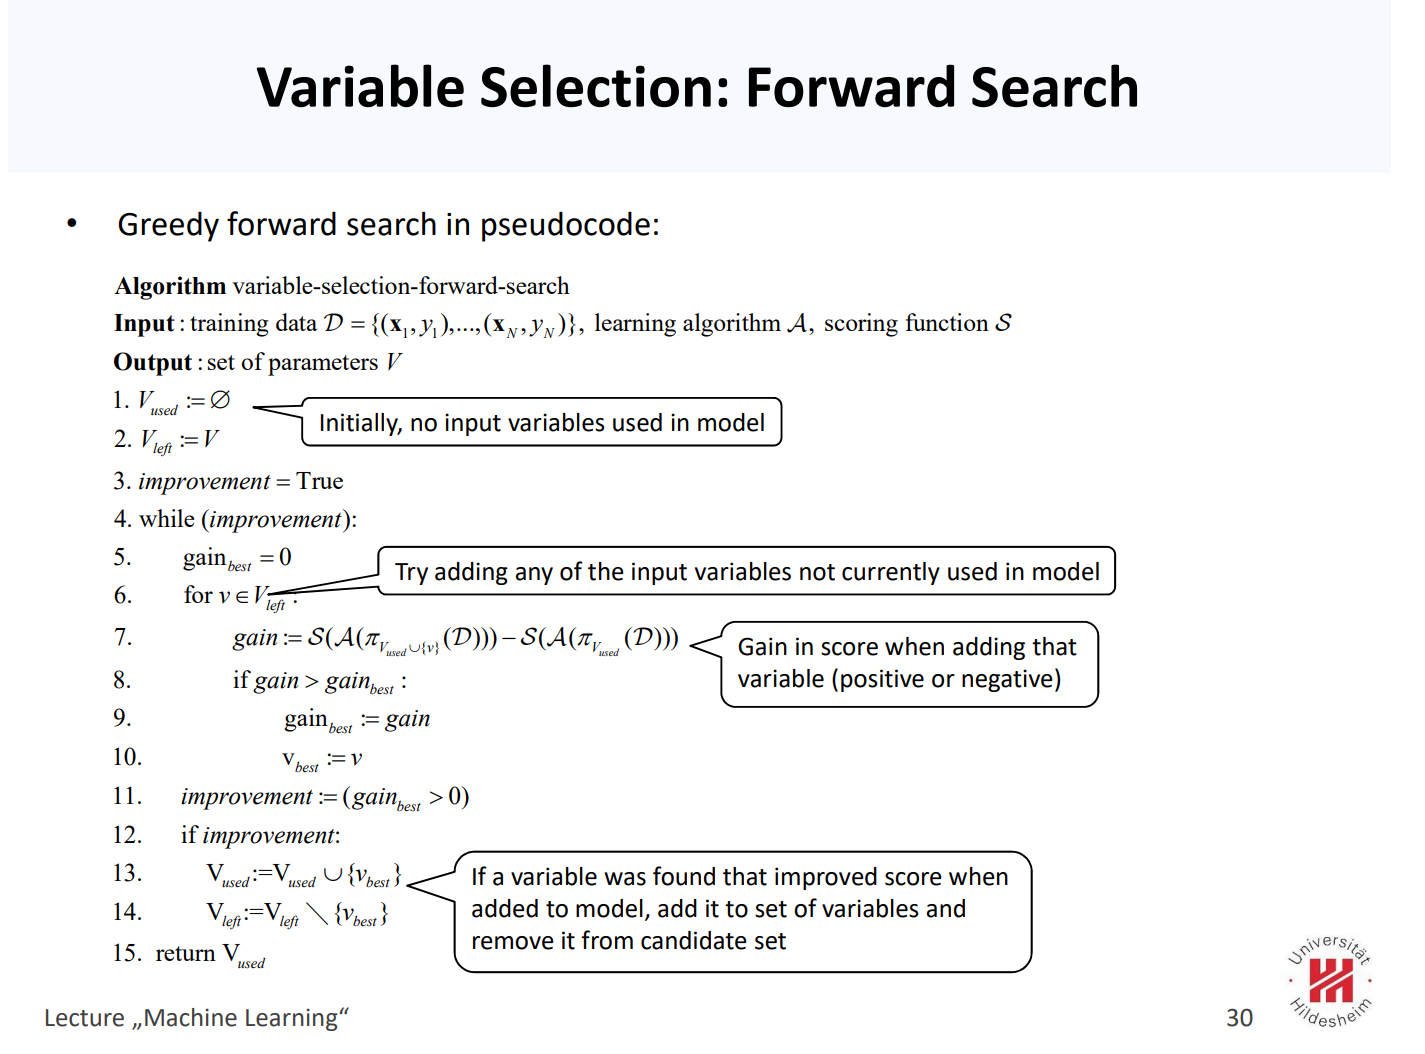

In [2]:
### Write your code here
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)



# Function to perform forward search
def forward_search(X_train, y_train, X_val, y_val):
    selected_features = []
    remaining_features = list(range(X_train.shape[1]))
    mse_in_iteration_before = float('inf')
    while remaining_features:
        best_feature = None
        best_mse = float('inf')

        for feature in remaining_features:
            model = Lars(n_nonzero_coefs=len(selected_features) + 1)
            model.fit(X_train[:, selected_features + [feature]], y_train)
            y_pred_val = model.predict(X_val[:, selected_features + [feature]])
            mse = mean_squared_error(y_val, y_pred_val)

            if mse < best_mse:
                best_mse = mse
                best_feature = feature

        if best_mse <= mse_in_iteration_before:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            mse_in_iteration_before = best_mse
        else:
            break

    return selected_features

# Function to perform backward search
def backward_search(X_train, y_train, X_val, y_val):
    selected_features = list(range(X_train.shape[1]))
    mse_in_iteration_before = float('inf')
    while len(selected_features) > 0:
        best_feature = None
        best_mse = float('inf')

        for feature in selected_features:
            remaining_features = selected_features.copy()
            remaining_features.remove(feature)
            model = Lars(n_nonzero_coefs=len(remaining_features))
            model.fit(X_train[:, remaining_features], y_train)
            y_pred_val = model.predict(X_val[:, remaining_features])
            mse = mean_squared_error(y_val, y_pred_val)

            if mse < best_mse:
                best_mse = mse
                best_feature = feature

        if best_mse <= mse_in_iteration_before:
            selected_features.remove(best_feature)
            mse_in_iteration_before = best_mse
        else:
            break
        
    return selected_features

# Perform forward search
forward_selected_features = forward_search(X_train, y_train, X_val, y_val)
print("Forward Selected Features:", forward_selected_features)

# Perform backward search
backward_selected_features = backward_search(X_train, y_train, X_val, y_val)
print("Backward Remaining Features:", backward_selected_features)

Forward Selected Features: [3, 1, 0, 4, 35, 84, 90, 62, 92, 74, 95, 27, 33, 58, 56, 94, 12, 76, 55, 71, 31, 39, 65, 59, 24, 50, 30, 68, 40, 7, 43, 60, 83, 54, 32, 18, 38, 51]
Backward Remaining Features: [0, 1, 3, 4, 7, 12, 18, 24, 27, 30, 31, 32, 33, 35, 38, 39, 40, 43, 50, 51, 54, 55, 56, 58, 59, 60, 62, 65, 68, 71, 74, 76, 83, 84, 90, 92, 94, 95]


**Backward Search**

The algorithm for backward search is given as:

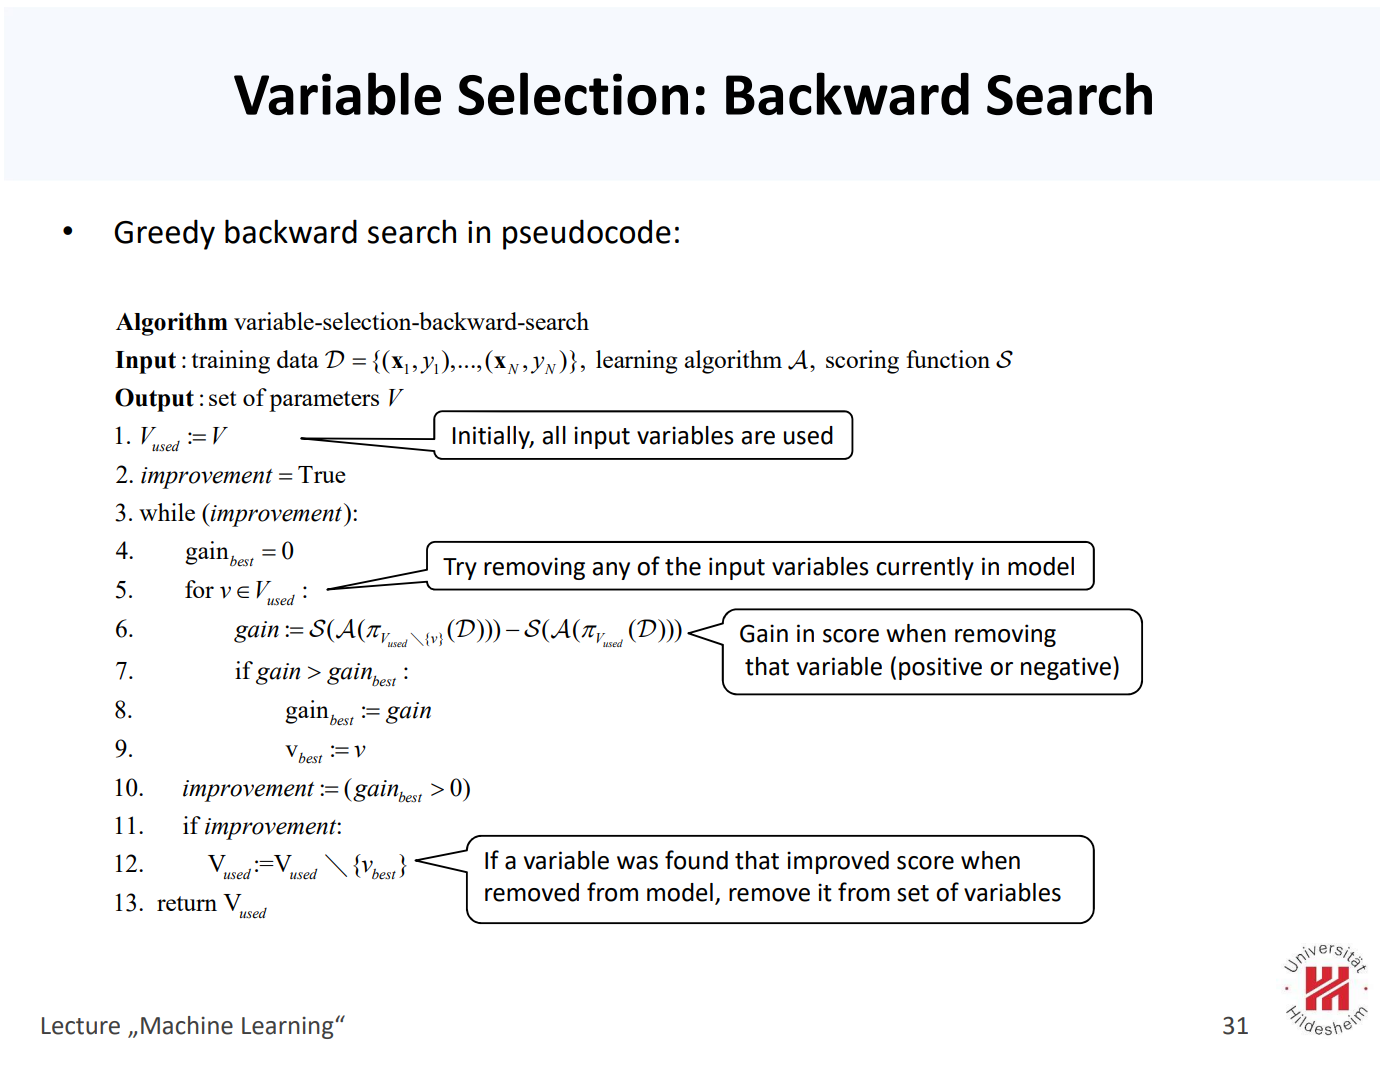



**Evaluation**

- Print out the indices of the selected features, compare the outputs of the two methods. Are the indices the same?
- Compare the performance of both methods on the test dataset.
- Comment on why we need a separate validation and test dataset in this case.

In [3]:
# Compare the performance on the test dataset
def evaluate_performance(X_train, y_train, X_test, y_test, selected_features):
    model = Lars(n_nonzero_coefs=len(selected_features))
    model.fit(X_train[:, selected_features], y_train)
    y_pred_test = model.predict(X_test[:, selected_features])
    mse_test = mean_squared_error(y_test, y_pred_test)
    return mse_test

# Evaluate forward search performance
mse_forward = evaluate_performance(X_train, y_train, X_test, y_test, forward_selected_features)
print("Forward Search MSE on Test Set:", mse_forward)

# Evaluate backward search performance
mse_backward = evaluate_performance(X_train, y_train, X_test, y_test, backward_selected_features)
print("Backward Search MSE on Test Set:", mse_backward)

Forward Search MSE on Test Set: 6.4892372964906775
Backward Search MSE on Test Set: 6.489237296490676


During the forward and backward search procedures, we make decisions about which features to include or exclude based on the validation set's performance. This process involves tuning the model hyperparameters or selecting the best subset of features. The test set should be kept entirely separate until the model is finalized to avoid any form of overfitting to the test set.

### Part 2 - Regularization and Hyperparameter Search


Variable selection via forward and backward search drops some predictors; in some cases, we don't want to remove these predictors. Rather we want their coefficients to be small as possible. We are going to test the effect of the regularization term alpha. We will use the same data as in Variable Selection. 

Furthermore, we will use following sklearn implementation: 
- Ridge regression (sklearn.linear_model.Ridge)
- Lasso (sklearn.linear_model.Lasso)
- Elastic-Net (sklearn.linear_model.ElasticNet)

You need to implement GridSearch and RandomSearch algorithms to tune the value of $\alpha$. In both case try 5 different values of $\alpha$. 

Remember to use the validation set to find the best hyperparameters.

In [10]:
# just for learning

from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
with open('variable_selection.npy', 'rb') as f:
    X = np.load(f)
    y = np.load(f)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = {'alpha': alphas}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train, y_train)
ridge_test_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, ridge_test_pred)


array([-5.88842673, -5.88842288, -5.88838499, -5.88806124, -5.89014644])

In [4]:
### Write your code here
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Load the dataset
with open('variable_selection.npy', 'rb') as f:
    X = np.load(f)
    y = np.load(f)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


# Function to perform Ridge regression with GridSearch
def ridge_grid_search(X_train, y_train, alphas):
    param_grid = {'alpha': alphas}
    ridge = Ridge()
    grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)
    best_alpha = grid_search.best_params_['alpha']
    # Train the final model with the best alpha on the combined train and validation sets
    final_model = Ridge(alpha=best_alpha)
    final_model.fit(X_train, y_train)

    return final_model, grid_search.cv_results_['mean_test_score']

# Function to perform Lasso regression with GridSearch
def lasso_grid_search(X_train, y_train, alphas):
    param_grid = {'alpha': alphas}
    lasso = Lasso()
    grid_search = GridSearchCV(lasso, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)
    best_alpha = grid_search.best_params_['alpha']

    # Train the final model with the best alpha on the combined train and validation sets
    final_model = Lasso(alpha=best_alpha)
    final_model.fit(X_train, y_train)

    return final_model, grid_search.cv_results_['mean_test_score']

# Function to perform Elastic-Net regression with GridSearch
def elastic_net_grid_search(X_train, y_train, alphas, l1_ratios):
    param_grid = {'alpha': alphas, 'l1_ratio': l1_ratios}
    elastic_net = ElasticNet()
    grid_search = GridSearchCV(elastic_net, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)
    best_alpha = grid_search.best_params_['alpha']
    best_l1_ratio = grid_search.best_params_['l1_ratio']

    # Train the final model with the best alpha and l1_ratio on the combined train and validation sets
    final_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
    final_model.fit(X_train, y_train)
    
    return final_model, grid_search.cv_results_['mean_test_score']

# Function to perform Ridge regression with RandomizedSearch
def ridge_random_search(X_train, y_train, alpha_distribution, n_iter):
    param_dist = {'alpha': alpha_distribution}
    ridge = Ridge()
    random_search = RandomizedSearchCV(ridge, param_distributions=param_dist, n_iter=n_iter,
                                            scoring='neg_mean_squared_error', cv=5)
    random_search.fit(X_train, y_train)
    best_alpha = random_search.best_params_['alpha']

    # Train the final model with the best alpha on the combined train and validation sets
    final_model = Ridge(alpha=best_alpha)
    final_model.fit(X_train, y_train)

    return final_model, random_search.cv_results_['mean_test_score'], random_search.cv_results_['param_alpha']

# Function to perform Lasso regression with RandomizedSearch
def lasso_random_search(X_train, y_train, alpha_distribution, n_iter):
    param_dist = {'alpha': alpha_distribution}
    lasso = Lasso()
    random_search = RandomizedSearchCV(lasso, param_distributions=param_dist, n_iter=n_iter,
                                            scoring='neg_mean_squared_error', cv=5)
    random_search.fit(X_train, y_train)
    best_alpha = random_search.best_params_['alpha']

    # Train the final model with the best alpha on the combined train and validation sets
    final_model = Lasso(alpha=best_alpha)
    final_model.fit(X_train, y_train)

    return final_model, random_search.cv_results_['mean_test_score'], random_search.cv_results_['param_alpha']

# Function to perform Elastic-Net regression with RandomizedSearch
def elastic_net_random_search(X_train, y_train, alpha_distribution, l1_ratio_distribution, n_iter):
    param_dist = {'alpha': alpha_distribution, 'l1_ratio': l1_ratio_distribution}
    elastic_net = ElasticNet()
    random_search = RandomizedSearchCV(elastic_net, param_distributions=param_dist, n_iter=n_iter,
                                            scoring='neg_mean_squared_error', cv=5)
    random_search.fit(X_train, y_train)
    best_alpha = random_search.best_params_['alpha']
    best_l1_ratio = random_search.best_params_['l1_ratio']

    # Train the final model with the best alpha and l1_ratio on the combined train and validation sets
    final_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
    final_model.fit(X_train, y_train)

    return final_model, random_search.cv_results_['mean_test_score'], random_search.cv_results_['param_alpha'], random_search.cv_results_['param_l1_ratio']

# Set of alpha values to try
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

# Set of alpha and l1_ratio values for Elastic-Net
l1_ratio_values = [0.1, 0.3, 0.5, 0.7, 0.9]

# Number of iterations for RandomizedSearch
n_iter_search = 5

# Perform Ridge regression with GridSearch
ridge_grid_model, ridge_grid_scores = ridge_grid_search(X_train, y_train, alphas)

# Perform Lasso regression with GridSearch
lasso_grid_model, lasso_grid_scores = lasso_grid_search(X_train, y_train, alphas)

# Perform Elastic-Net regression with GridSearch
elastic_net_grid_model, elastic_net_grid_scores = elastic_net_grid_search(X_train, y_train, alphas, l1_ratio_values)

# Perform Ridge regression with RandomizedSearch
ridge_random_model, ridge_random_scores, ridge_random_alphas = ridge_random_search(X_train, y_train, alphas, n_iter_search)

# Perform Lasso regression with RandomizedSearch
lasso_random_model, lasso_random_scores, lasso_random_alphas = lasso_random_search(X_train, y_train, alphas, n_iter_search)

# Perform Elastic-Net regression with RandomizedSearch
elastic_net_random_model, elastic_net_random_scores, elastic_net_random_alphas, elastic_netrandom_l1_ratios = elastic_net_random_search(X_train, y_train, alphas, l1_ratio_values, n_iter_search)

# Evaluate the models on the test set
ridge_test_pred = ridge_grid_model.predict(X_test)
lasso_test_pred = lasso_grid_model.predict(X_test)
elastic_net_test_pred = elastic_net_grid_model.predict(X_test)

ridge_random_test_pred = ridge_random_model.predict(X_test)
lasso_random_test_pred = lasso_random_model.predict(X_test)
elastic_net_random_test_pred = elastic_net_random_model.predict(X_test)

ridge_test_mse = mean_squared_error(y_test, ridge_test_pred)
lasso_test_mse = mean_squared_error(y_test, lasso_test_pred)
elastic_net_test_mse = mean_squared_error(y_test, elastic_net_test_pred)

ridge_random_test_mse = mean_squared_error(y_test, ridge_random_test_pred)
lasso_random_test_mse = mean_squared_error(y_test, lasso_random_test_pred)
elastic_net_random_test_mse = mean_squared_error(y_test, elastic_net_random_test_pred)

# Print the results
print("Ridge (GridSearch) Test MSE:", ridge_test_mse)
print("Lasso (GridSearch) Test MSE:", lasso_test_mse)
print("Elastic-Net (GridSearch) Test MSE:", elastic_net_test_mse)

print("Ridge (RandomizedSearch) Test MSE:", ridge_random_test_mse)
print("Lasso (RandomizedSearch) Test MSE:", lasso_random_test_mse)
print("Elastic-Net (RandomizedSearch) Test MSE:", elastic_net_random_test_mse)

Ridge (GridSearch) Test MSE: 6.30627907736322
Lasso (GridSearch) Test MSE: 6.248150088884491
Elastic-Net (GridSearch) Test MSE: 6.2530577286006155
Ridge (RandomizedSearch) Test MSE: 6.30627907736322
Lasso (RandomizedSearch) Test MSE: 6.248150088884491
Elastic-Net (RandomizedSearch) Test MSE: 6.285728304897867


Plot a graph of $\alpha$ values vs loss for all models (one for GridSearch and one for RandomSearch). Also report the test loss for the all three models using the best $\alpha$ values.

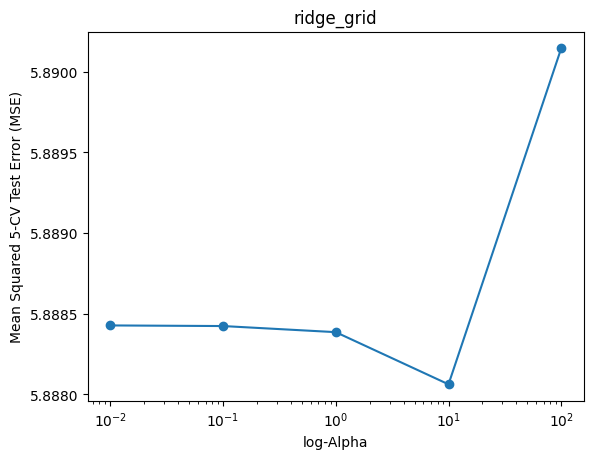

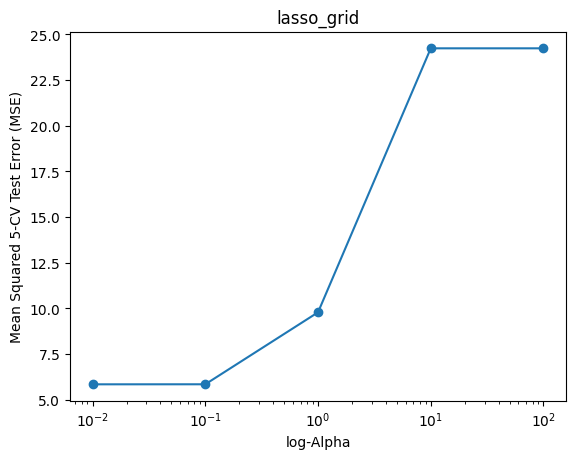

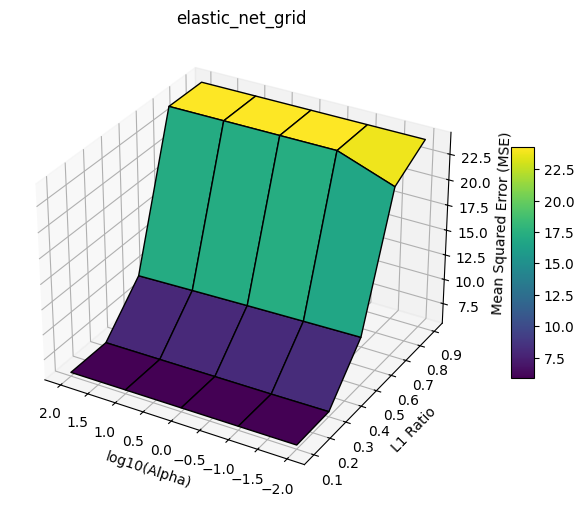

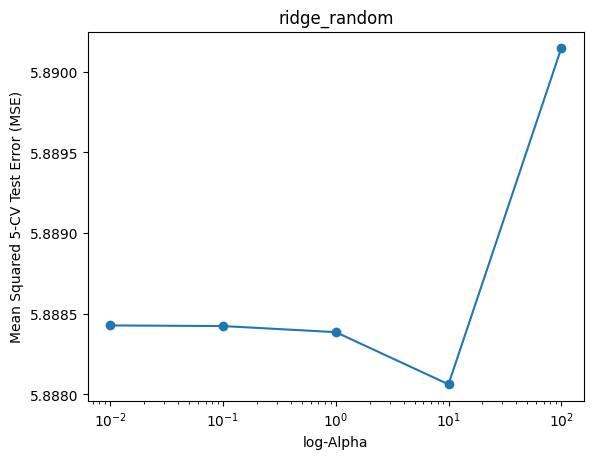

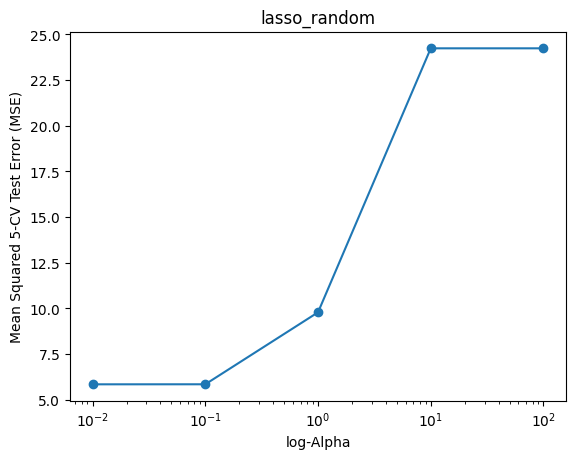

TypeError: loop of ufunc does not support argument 0 of type float which has no callable log10 method

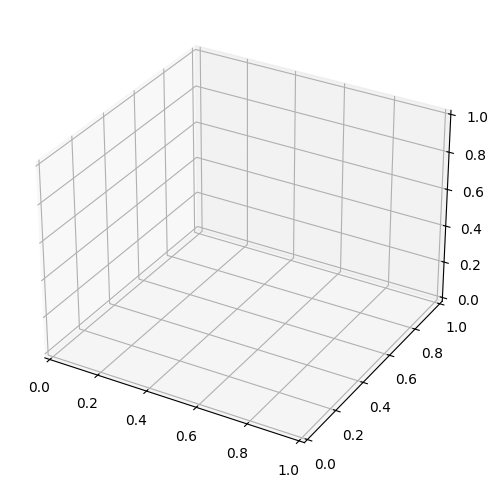

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot alpha values vs loss
def plot_alpha_vs_loss(alphas, losses, title):
    plt.plot(alphas, losses, marker='o')
    plt.xscale('log')  # Use log scale for better visualization
    plt.xlabel('log-Alpha')
    plt.ylabel('Mean Squared 5-CV Test Error (MSE)')
    plt.title(title)
    plt.show()

def plot_3d_surface(alphas, l1_ratios, mean_test_scores, title, reshape):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    if reshape:
        mean_test_scores = np.array(mean_test_scores).reshape(len(l1_ratios), len(alphas))

    # Create a meshgrid for 3D plotting
    alphas, l1_ratios = np.meshgrid(alphas, l1_ratios)
    
    # Plot 3D surface
    surface = ax.plot_surface(np.log10(alphas), l1_ratios, mean_test_scores, cmap='viridis', edgecolor='k')
    
    # Customize the plot
    ax.set_xlabel('log10(Alpha)')
    ax.set_ylabel('L1 Ratio')
    ax.set_zlabel('Mean Squared Error (MSE)')
    ax.set_title(title)
    ax.invert_xaxis()  # Invert x-axis for better visualization
    
    # Add colorbar
    fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)
    
    plt.show()

# plotting alphas for grid
plot_alpha_vs_loss(alphas, -ridge_grid_scores, 'ridge_grid')
plot_alpha_vs_loss(alphas, -lasso_grid_scores, 'lasso_grid')
plot_3d_surface(alphas, l1_ratio_values, -elastic_net_grid_scores, 'elastic_net_grid', True)
# plotting alphas for random search
plot_alpha_vs_loss(ridge_random_alphas, -ridge_random_scores, 'ridge_random')
plot_alpha_vs_loss(lasso_random_alphas, -lasso_random_scores, 'lasso_random')
plot_3d_surface(np.array(elastic_net_random_alphas), np.array(elastic_netrandom_l1_ratios), -np.diag(np.array(elastic_net_random_scores)), 'elastic_net_grid', True)
print(f'Best loss is: {min(ridge_test_mse, lasso_test_mse, elastic_net_test_mse, ridge_random_test_mse, lasso_random_test_mse, elastic_net_random_test_mse)}')


The error is because of the existance of ZERO in the random selected alphas or l1-scores - Since we take LOG_10

### Comparison

Select the least test loss model from both of the above parts:
- Model A: from Variable Selection
- Model B: from Regularization and Hyperparameter Search

Find the list of variables not selected in Model A, use this list to separate the coefficients of the model B into two groups. Comment on the difference in the values of the coefficients of these groups.

The best model is Lasso Grid search

In [34]:
print(f'used coefs : {lasso_grid_model.coef_[forward_selected_features]}')
diff = [x for x in range(X_scaled.shape[1]) if x not in forward_selected_features] 
print(f'not used coefs : {lasso_grid_model.coef_[diff]}')

used coefs : [ 2.85910227  1.86954557  1.90439594  1.46729602 -0.00900281 -0.00412598
  0.          0.01225058  0.          0.01929222 -0.         -0.
  0.         -0.         -0.         -0.          0.         -0.
  0.01659282 -0.         -0.         -0.          0.          0.
  0.          0.          0.          0.         -0.         -0.
 -0.          0.          0.          0.         -0.          0.
 -0.          0.        ]
not used coefs : [ 0.00796908  0.          0.          0.          0.          0.
  0.          0.          0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.         -0.          0.
  0.         -0.         -0.00558468  0.          0.         -0.
 -0.          0.01747143 -0.          0.00899828  0.         -0.
  0.         -0.          0.          0.         -0.          0.
 -0.          0.         -0.         -0.         -0.         -0.0009423
  0.          0.         -0.         -0.         -0.02833732  0.
 -0.          0.002

the used ones are mostly bigger numbers as apoosed to the not used ones which are mostly little 